In [2]:
import findspark
import pandas as pd
findspark.init()
findspark.find()
import numpy as np

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
spark = (
    SparkSession
    .builder
    .appName("sparktest")
    .master("local[6]")
    .getOrCreate()
)
#A SparkContext represents the connection to a Spark cluster, and can be used to create RDD and broadcast variables on that cluster. It is the first step to using RDDs and connecting to a cluster

sc = spark.sparkContext
spark

23/07/20 15:08:52 WARN Utils: Your hostname, Hamsas-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.152 instead (on interface en0)
23/07/20 15:08:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/20 15:08:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#can read csv using sc.textFile("C:/...")

In [5]:
import findspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt

In [6]:
spark = SparkSession \
        .builder \
        .appName("firstSpark") \
        .getOrCreate()

23/07/20 15:08:58 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [7]:
#convert csv from data_scrape into a spark dataframe
df = spark.read.format('csv').options(header = 'true').load('serieA-matches.csv')
df.limit(5).show()

+---+---+---+----------+----+---------+-------------+-----+--------+----------+-----+-------------------+---------+---------+-----------+----+----+-----+
|_c0| Wk|Day|      Date|Time|   Season|         Home|Score|    Away|Attendance|Venue|            Referee|HomeGoals|AwayGoals|FinalResult|  xG|xG.1|Round|
+---+---+---+----------+----+---------+-------------+-----+--------+----------+-----+-------------------+---------+---------+-----------+----+----+-----+
|  0|1.0|Sat|2013-08-24|null|2013-2014|    Sampdoria|  0–1|Juventus|      null| null|         Luca Banti|        0|        1|          A|null|null| null|
|  1|1.0|Sat|2013-08-24|null|2013-2014|Hellas Verona|  2–1|   Milan|      null| null|Gianpaolo Calvarese|        2|        1|          H|null|null| null|
|  2|1.0|Sun|2013-08-25|null|2013-2014|       Napoli|  3–0| Bologna|      null| null|    Andrea De Marco|        3|        0|          H|null|null| null|
|  3|1.0|Sun|2013-08-25|null|2013-2014|     Cagliari|  2–1|Atalanta|      nu

23/07/20 15:09:05 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Wk, Day, Date, Time, Season, Home, Score, Away, Attendance, Venue, Referee, HomeGoals, AwayGoals, FinalResult, xG, xG.1, Round
 Schema: _c0, Wk, Day, Date, Time, Season, Home, Score, Away, Attendance, Venue, Referee, HomeGoals, AwayGoals, FinalResult, xG, xG.1, Round
Expected: _c0 but found: 
CSV file: file:///Users/hamzawork/Data_engineering/spark101/serieA-matches.csv


In [8]:
#converts to pandas
df.limit(5).toPandas()

23/07/20 15:09:06 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Wk, Day, Date, Time, Season, Home, Score, Away, Attendance, Venue, Referee, HomeGoals, AwayGoals, FinalResult, xG, xG.1, Round
 Schema: _c0, Wk, Day, Date, Time, Season, Home, Score, Away, Attendance, Venue, Referee, HomeGoals, AwayGoals, FinalResult, xG, xG.1, Round
Expected: _c0 but found: 
CSV file: file:///Users/hamzawork/Data_engineering/spark101/serieA-matches.csv


,_c0,Wk,Day,Date,Time,Season,Home,Score,Away,Attendance,Venue,Referee,HomeGoals,AwayGoals,FinalResult,xG,xG.1,Round
0,0,1.0,Sat,2013-08-24,None,2013-2014,Sampdoria,0–1,Juventus,None,None,Luca Banti,0,1,A,None,None,None
1,1,1.0,Sat,2013-08-24,None,2013-2014,Hellas Verona,2–1,Milan,None,None,Gianpaolo Calvarese,2,1,H,None,None,None
2,2,1.0,Sun,2013-08-25,None,2013-2014,Napoli,3–0,Bologna,None,None,Andrea De Marco,3,0,H,None,None,None
3,3,1.0,Sun,2013-08-25,None,2013-2014,Cagliari,2–1,Atalanta,None,None,Massimiliano Irrati,2,1,H,None,None,None
4,4,1.0,Sun,2013-08-25,None,2013-2014,Parma,0–0,Chievo,None,None,Nicola Rizzoli,0,0,D,None,None,None


In [9]:
#who are the winners of the serie A in the last 10 years?

In [10]:
#create 3 new columns that stand for the number of home, away wins and draws
df_matches = df.withColumn('HomeTeamWin', when (col('FinalResult') == 'H', 1).otherwise(0))\
             .withColumn('AwayTeamWin', when(col('FinalResult') == 'A', 1).otherwise(0)) \
             .withColumn('GameDraw', when(col('FinalResult') == 'D', 1).otherwise(0))


In [11]:
#remove any unnecessary columns we may not use
df_matches = df_matches.drop(*['Attendance','Referee','Round'])


In [12]:
#create a dataframe that groups home matches data such as the number of home wins,losses, home goals, goals conceded and call it home
home = df_matches.groupby('Season','Home')\
       .agg(sum('HomeTeamWin').alias('TotalHomeWin'),
           sum('AwayTeamWin').alias('TotalHomeLoss'),
           sum('GameDraw').alias('TotalHomeDraw'),
           sum('HomeGoals').alias('HomeScoredGoals'),
           sum('AwayGoals').alias('HomeAgainstGoals'))\
       .withColumnRenamed('Home','Team')
home.toPandas()

,Season,Team,TotalHomeWin,TotalHomeLoss,TotalHomeDraw,HomeScoredGoals,HomeAgainstGoals
0,2019-2020,Fiorentina,5,6,8,22.0,22.0
1,2017-2018,Crotone,6,7,6,23.0,25.0
2,2022-2023,Juventus,13,3,3,38.0,15.0
3,2022-2023,Bologna,7,3,9,24.0,14.0
4,2020-2021,Napoli,12,3,4,50.0,20.0
...,...,...,...,...,...,...,...
195,2018-2019,Torino,12,5,2,32.0,19.0
196,2015-2016,Chievo,7,4,8,25.0,18.0
197,2018-2019,Napoli,13,2,4,41.0,16.0
198,2020-2021,Bologna,7,7,5,33.0,33.0


In [13]:
#do the same for away matches
away = df_matches.groupby('Season','Away')\
       .agg(sum('AwayTeamWin').alias('TotalAwayWin'),
           sum('HomeTeamWin').alias('TotalAwayLoss'),
           sum('GameDraw').alias('TotalAwayDraw'),
           sum('AwayGoals').alias('AwayScoredGoals'),
           sum('HomeGoals').alias('AwayAgainstGoals'))\
       .withColumnRenamed('Away','Team')

In [14]:
home.toPandas()

,Season,Team,TotalHomeWin,TotalHomeLoss,TotalHomeDraw,HomeScoredGoals,HomeAgainstGoals
0,2019-2020,Fiorentina,5,6,8,22.0,22.0
1,2017-2018,Crotone,6,7,6,23.0,25.0
2,2022-2023,Juventus,13,3,3,38.0,15.0
3,2022-2023,Bologna,7,3,9,24.0,14.0
4,2020-2021,Napoli,12,3,4,50.0,20.0
...,...,...,...,...,...,...,...
195,2018-2019,Torino,12,5,2,32.0,19.0
196,2015-2016,Chievo,7,4,8,25.0,18.0
197,2018-2019,Napoli,13,2,4,41.0,16.0
198,2020-2021,Bologna,7,7,5,33.0,33.0


In [15]:
#order by the window which is the Season but the ranking is in descending order by win percentage and goal difference taking the second priority. Also inner join on Team and season to create a single df containing each Serie A table season. Remove any unnecessary columns too

window = ['Season']
window = Window.partitionBy(window).orderBy(col('WinPct').desc(), col('GoalDifferentials').desc())
table = home.join(away, ['Team', 'Season'],  'inner') \
    .withColumn('GoalsScored', col('HomeScoredGoals') + col('AwayScoredGoals')) \
    .withColumn('GoalsAgainst', col('HomeAgainstGoals') + col('AwayAgainstGoals')) \
    .withColumn('GoalDifferentials', col('GoalsScored') - col('GoalsAgainst')) \
    .withColumn('Win', col('TotalHomeWin') + col('TotalAwayWin')) \
    .withColumn('Loss', col('TotalHomeLoss') + col('TotalAwayLoss')) \
    .withColumn('Tie', col('TotalHomeDraw') + col('TotalAwayDraw')) \
    .withColumn('WinPct', round((100* col('Win')/(col('Win') + col('Loss') + col('Tie'))), 2)) \
    .drop('HomeScoredGoals', 'AwayScoredGoals', 'HomeAgainstGoals', 'AwayAgainstGoals') \
    .drop('TotalHomeWin', 'TotalAwayWin', 'TotalHomeLoss', 'TotalAwayLoss', 'TotalHomeDraw', 'TotalAwayDraw') \
    .withColumn('TeamPosition', rank().over(window)) 
table_df = table.filter(col('TeamPosition') == 1).orderBy(asc('Season')).toPandas()
table_df

,Team,Season,GoalsScored,GoalsAgainst,GoalDifferentials,Win,Loss,Tie,WinPct,TeamPosition
0,Juventus,2013-2014,80.0,23.0,57.0,33,2,3,86.84,1
1,Juventus,2014-2015,72.0,24.0,48.0,26,3,9,68.42,1
2,Juventus,2015-2016,75.0,20.0,55.0,29,5,4,76.32,1
3,Juventus,2016-2017,77.0,27.0,50.0,29,5,4,76.32,1
4,Juventus,2017-2018,86.0,24.0,62.0,30,3,5,78.95,1
5,Juventus,2018-2019,70.0,30.0,40.0,28,4,6,73.68,1
6,Juventus,2019-2020,76.0,43.0,33.0,26,7,5,68.42,1
7,Inter,2020-2021,89.0,35.0,54.0,28,3,7,73.68,1
8,Milan,2021-2022,69.0,31.0,38.0,26,4,8,68.42,1
9,Napoli,2022-2023,77.0,28.0,49.0,28,4,6,73.68,1


In [19]:
#same here but totalpoint as first ranking criteria is used

window = ['Season']
window_totalpoints = Window.partitionBy(window).orderBy(col('TotalPoints').desc(), col('GoalDifferentials').desc())
table_totalpoints = home.join(away, ['Team', 'Season'],  'inner') \
    .withColumn('GoalsScored', col('HomeScoredGoals') + col('AwayScoredGoals')) \
    .withColumn('GoalsAgainst', col('HomeAgainstGoals') + col('AwayAgainstGoals')) \
    .withColumn('GoalDifferentials', col('GoalsScored') - col('GoalsAgainst')) \
    .withColumn('Win', col('TotalHomeWin') + col('TotalAwayWin')) \
    .withColumn('Loss', col('TotalHomeLoss') + col('TotalAwayLoss')) \
    .withColumn('Tie', col('TotalHomeDraw') + col('TotalAwayDraw')) \
    .withColumn('TotalPoints', (col('Win') *3 + col('Tie'))) \
    .drop('HomeScoredGoals', 'AwayScoredGoals', 'HomeAgainstGoals', 'AwayAgainstGoals') \
    .drop('TotalHomeWin', 'TotalAwayWin', 'TotalHomeLoss', 'TotalAwayLoss', 'TotalHomeDraw', 'TotalAwayDraw') \
    .withColumn('TeamPosition', rank().over(window_totalpoints))
totalpoints_df = table_totalpoints.filter(col('TeamPosition') == 1).orderBy(asc('Season')).toPandas()
totalpoints_df

,Team,Season,GoalsScored,GoalsAgainst,GoalDifferentials,Win,Loss,Tie,TotalPoints,TeamPosition
0,Juventus,2013-2014,80.0,23.0,57.0,33,2,3,102,1
1,Juventus,2014-2015,72.0,24.0,48.0,26,3,9,87,1
2,Juventus,2015-2016,75.0,20.0,55.0,29,5,4,91,1
3,Juventus,2016-2017,77.0,27.0,50.0,29,5,4,91,1
4,Juventus,2017-2018,86.0,24.0,62.0,30,3,5,95,1
5,Juventus,2018-2019,70.0,30.0,40.0,28,4,6,90,1
6,Juventus,2019-2020,76.0,43.0,33.0,26,7,5,83,1
7,Inter,2020-2021,89.0,35.0,54.0,28,3,7,91,1
8,Milan,2021-2022,69.0,31.0,38.0,26,4,8,86,1
9,Napoli,2022-2023,77.0,28.0,49.0,28,4,6,90,1


In [22]:
#Which teams have been relegated in the last 3 years?
relegated = table_totalpoints.filter(col('TeamPosition') > 17).orderBy(asc('Season'))
relegated.toPandas()

,Team,Season,GoalsScored,GoalsAgainst,GoalDifferentials,Win,Loss,Tie,TotalPoints,TeamPosition
0,Catania,2013-2014,34.0,66.0,-32.0,8,22,8,32,18
1,Bologna,2013-2014,28.0,58.0,-30.0,5,19,14,29,19
2,Livorno,2013-2014,39.0,77.0,-38.0,6,25,7,25,20
3,Cagliari,2014-2015,48.0,68.0,-20.0,8,20,10,34,18
4,Parma,2014-2015,33.0,75.0,-42.0,6,24,8,26,19
5,Cesena,2014-2015,36.0,73.0,-37.0,4,22,12,24,20
6,Carpi,2015-2016,37.0,57.0,-20.0,9,18,11,38,18
7,Frosinone,2015-2016,35.0,76.0,-41.0,8,23,7,31,19
8,Hellas Verona,2015-2016,34.0,63.0,-29.0,5,20,13,28,20
9,Empoli,2016-2017,29.0,61.0,-32.0,8,22,8,32,18


In [23]:
#Does the winter affect the perfomance of the Serie A
#compare overall win percentage for each team with the average win percentage over the winter and look at charts
#generate a chart of win percentage fluctuating over the season, so do a cumulating sum of wins and away wins

In [24]:
#Which season of the Serie A was the most competitive in the last decade?
#Find which season has the least points difference between first and sixth
competitive_df = table_totalpoints.filter((col('TeamPosition') == 1) | (col('TeamPosition') == 6)).orderBy(asc('Season')).drop('Team')
# Define the window specification partitioned by 'Season'
window_spec = Window.partitionBy('Season').orderBy('Season')
# Calculate the difference between rows with the same 'Season' value(this row and the next one which is what lead is referring to)
df_with_diff = competitive_df.withColumn('Difference', col('TotalPoints') - lead(col('TotalPoints')).over(window_spec)).drop('GoalsScored','GoalsAgainst','GoalDifferentials','Win','Loss','Tie','TotalPoint','TeamPosition','TotalPoints')
df_with_diff.toPandas().dropna()

,Season,Difference
0,2013-2014,44.0
2,2014-2015,28.0
4,2015-2016,30.0
6,2016-2017,28.0
8,2017-2018,31.0
10,2018-2019,24.0
12,2019-2020,17.0
14,2020-2021,23.0
16,2021-2022,23.0
18,2022-2023,26.0


In [25]:
#What's the best month to watch Serie A
#find which month of the season has the highest average goals scored in the league
#, include date and month in groupby transformation, do total of goals scored based on season and monthly window.
totalgoals = table_totalpoints.groupby('Season').sum('GoalsScored').orderBy(asc('Season'))
totalgoals.toPandas()

,Season,sum(GoalsScored)
0,2013-2014,1035.0
1,2014-2015,1024.0
2,2015-2016,979.0
3,2016-2017,1123.0
4,2017-2018,1017.0
5,2018-2019,1019.0
6,2019-2020,1154.0
7,2020-2021,1163.0
8,2021-2022,1089.0
9,2022-2023,974.0


In [26]:
#Does the winter affect the perfomance of the Serie A
#compare overall win percentage for each team with the average win percentage over the winter and look at charts
#generate a chart of win percentage fluctuating over the season, so do a cumulating sum of wins and away wins
#for now we will look at monthly goals scored in each month and look at the winter months in comparison

In [27]:
#create new dataframes to use for finding monthly goals
#create new date columns in orderto extract month
df_goals = df.withColumn('Date', to_date(df['Date']))
df_goals  = df_goals .withColumn('Month', month(df_goals ['Date']))
df_goals = df_goals.withColumn('MonthLabel', date_format(df_goals['Date'], 'MMMM'))
df_goals.toPandas()

23/07/20 15:11:18 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Wk, Day, Date, Time, Season, Home, Score, Away, Attendance, Venue, Referee, HomeGoals, AwayGoals, FinalResult, xG, xG.1, Round
 Schema: _c0, Wk, Day, Date, Time, Season, Home, Score, Away, Attendance, Venue, Referee, HomeGoals, AwayGoals, FinalResult, xG, xG.1, Round
Expected: _c0 but found: 
CSV file: file:///Users/hamzawork/Data_engineering/spark101/serieA-matches.csv


,_c0,Wk,Day,Date,Time,Season,Home,Score,Away,Attendance,Venue,Referee,HomeGoals,AwayGoals,FinalResult,xG,xG.1,Round,Month,MonthLabel
0,0,1.0,Sat,2013-08-24,None,2013-2014,Sampdoria,0–1,Juventus,None,None,Luca Banti,0,1,A,None,None,None,8,August
1,1,1.0,Sat,2013-08-24,None,2013-2014,Hellas Verona,2–1,Milan,None,None,Gianpaolo Calvarese,2,1,H,None,None,None,8,August
2,2,1.0,Sun,2013-08-25,None,2013-2014,Napoli,3–0,Bologna,None,None,Andrea De Marco,3,0,H,None,None,None,8,August
3,3,1.0,Sun,2013-08-25,None,2013-2014,Cagliari,2–1,Atalanta,None,None,Massimiliano Irrati,2,1,H,None,None,None,8,August
4,4,1.0,Sun,2013-08-25,None,2013-2014,Parma,0–0,Chievo,None,None,Nicola Rizzoli,0,0,D,None,None,None,8,August
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,412,38.0,Sun,2023-06-04,21:00,2022-2023,Atalanta,5–2,Monza,19389.0,Gewiss Stadium,Marco Di Bello,5,2,H,4.0,1.2,Regular season,6,June
3796,413,38.0,Sun,2023-06-04,21:00,2022-2023,Milan,3–1,Hellas Verona,72102.0,Stadio Giuseppe Meazza,Paolo Valeri,3,1,H,2.4,0.8,Regular season,6,June
3797,414,38.0,Sun,2023-06-04,21:00,2022-2023,Udinese,0–1,Juventus,23266.0,Dacia Arena,Marco Guida,0,1,A,0.8,1.3,Regular season,6,June
3798,415,38.0,Sun,2023-06-04,21:00,2022-2023,Lecce,2–3,Bologna,25816.0,Stadio Comunale Via Del Mare,Marco Piccinini,2,3,A,1.4,1.1,Regular season,6,June


In [28]:
home_goals = df_goals.groupby('Season','Home','MonthLabel','Month')\
       .agg(
           sum('HomeGoals').alias('HomeScoredGoals'),
           sum('AwayGoals').alias('HomeAgainstGoals'))\
       .withColumnRenamed('Home','Team')
home_goals.limit(10).toPandas()

,Season,Team,MonthLabel,Month,HomeScoredGoals,HomeAgainstGoals
0,2013-2014,Catania,April,4,3.0,3.0
1,2013-2014,Atalanta,May,5,2.0,1.0
2,2014-2015,Sassuolo,October,10,4.0,2.0
3,2014-2015,Juventus,January,1,7.0,1.0
4,2015-2016,Torino,December,12,1.0,2.0
5,2016-2017,Sampdoria,September,9,0.0,1.0
6,2018-2019,Parma,November,11,2.0,1.0
7,2018-2019,Empoli,February,2,5.0,2.0
8,2019-2020,Juventus,August,8,5.0,6.0
9,2020-2021,Napoli,January,1,9.0,2.0


In [29]:
away_goals = df_goals.groupby('Season','Away','MonthLabel','Month')\
       .agg(
           sum('AwayGoals').alias('AwayScoredGoals'),
           sum('HomeGoals').alias('AwayAgainstGoals'))\
       .withColumnRenamed('Away','Team')
away_goals.limit(10).toPandas()

,Season,Team,MonthLabel,Month,AwayScoredGoals,AwayAgainstGoals
0,2013-2014,Catania,April,4,0.0,5.0
1,2013-2014,Atalanta,May,5,1.0,3.0
2,2014-2015,Sassuolo,October,10,5.0,4.0
3,2014-2015,Juventus,January,1,3.0,1.0
4,2016-2017,Sampdoria,September,9,3.0,7.0
5,2018-2019,Parma,November,11,2.0,1.0
6,2018-2019,Empoli,February,2,0.0,4.0
7,2019-2020,Juventus,August,8,1.0,0.0
8,2020-2021,Napoli,January,1,7.0,5.0
9,2021-2022,Lazio,October,10,3.0,9.0


In [30]:
window_goals = ['Season','MonthLabel','Month']
window_goals = Window.partitionBy(window_goals).orderBy(col('GoalsScored').desc())
table_goals = home_goals.join(away_goals, ['Team', 'Season','MonthLabel','Month'],  'inner') \
    .withColumn('GoalsScored', col('HomeScoredGoals') + col('AwayScoredGoals')) \
    .withColumn('GoalsAgainst', col('HomeAgainstGoals') + col('AwayAgainstGoals')) \
    .withColumn('GoalDifferentials', col('GoalsScored') - col('GoalsAgainst')) 
table_goals.limit(20).toPandas()

,Team,Season,MonthLabel,Month,HomeScoredGoals,HomeAgainstGoals,AwayScoredGoals,AwayAgainstGoals,GoalsScored,GoalsAgainst,GoalDifferentials
0,Catania,2013-2014,April,4,3.0,3.0,0.0,5.0,3.0,8.0,-5.0
1,Atalanta,2013-2014,May,5,2.0,1.0,1.0,3.0,3.0,4.0,-1.0
2,Sassuolo,2014-2015,October,10,4.0,2.0,5.0,4.0,9.0,6.0,3.0
3,Juventus,2014-2015,January,1,7.0,1.0,3.0,1.0,10.0,2.0,8.0
4,Sampdoria,2016-2017,September,9,0.0,1.0,3.0,7.0,3.0,8.0,-5.0
5,Parma,2018-2019,November,11,2.0,1.0,2.0,1.0,4.0,2.0,2.0
6,Empoli,2018-2019,February,2,5.0,2.0,0.0,4.0,5.0,6.0,-1.0
7,Juventus,2019-2020,August,8,5.0,6.0,1.0,0.0,6.0,6.0,0.0
8,Napoli,2020-2021,January,1,9.0,2.0,7.0,5.0,16.0,7.0,9.0
9,Lazio,2021-2022,October,10,4.0,1.0,3.0,9.0,7.0,10.0,-3.0


In [37]:
monthly_goals = table_goals.groupby('MonthLabel','Season','Month').sum('GoalsScored')
monthly_goals  = monthly_goals .withColumn('SeasonOrder', when(col('Month') >= 8, col('Month') - 7).otherwise(col('Month') + 5))
monthly_goals_pandas  = monthly_goals .orderBy('Season','SeasonOrder').toPandas()

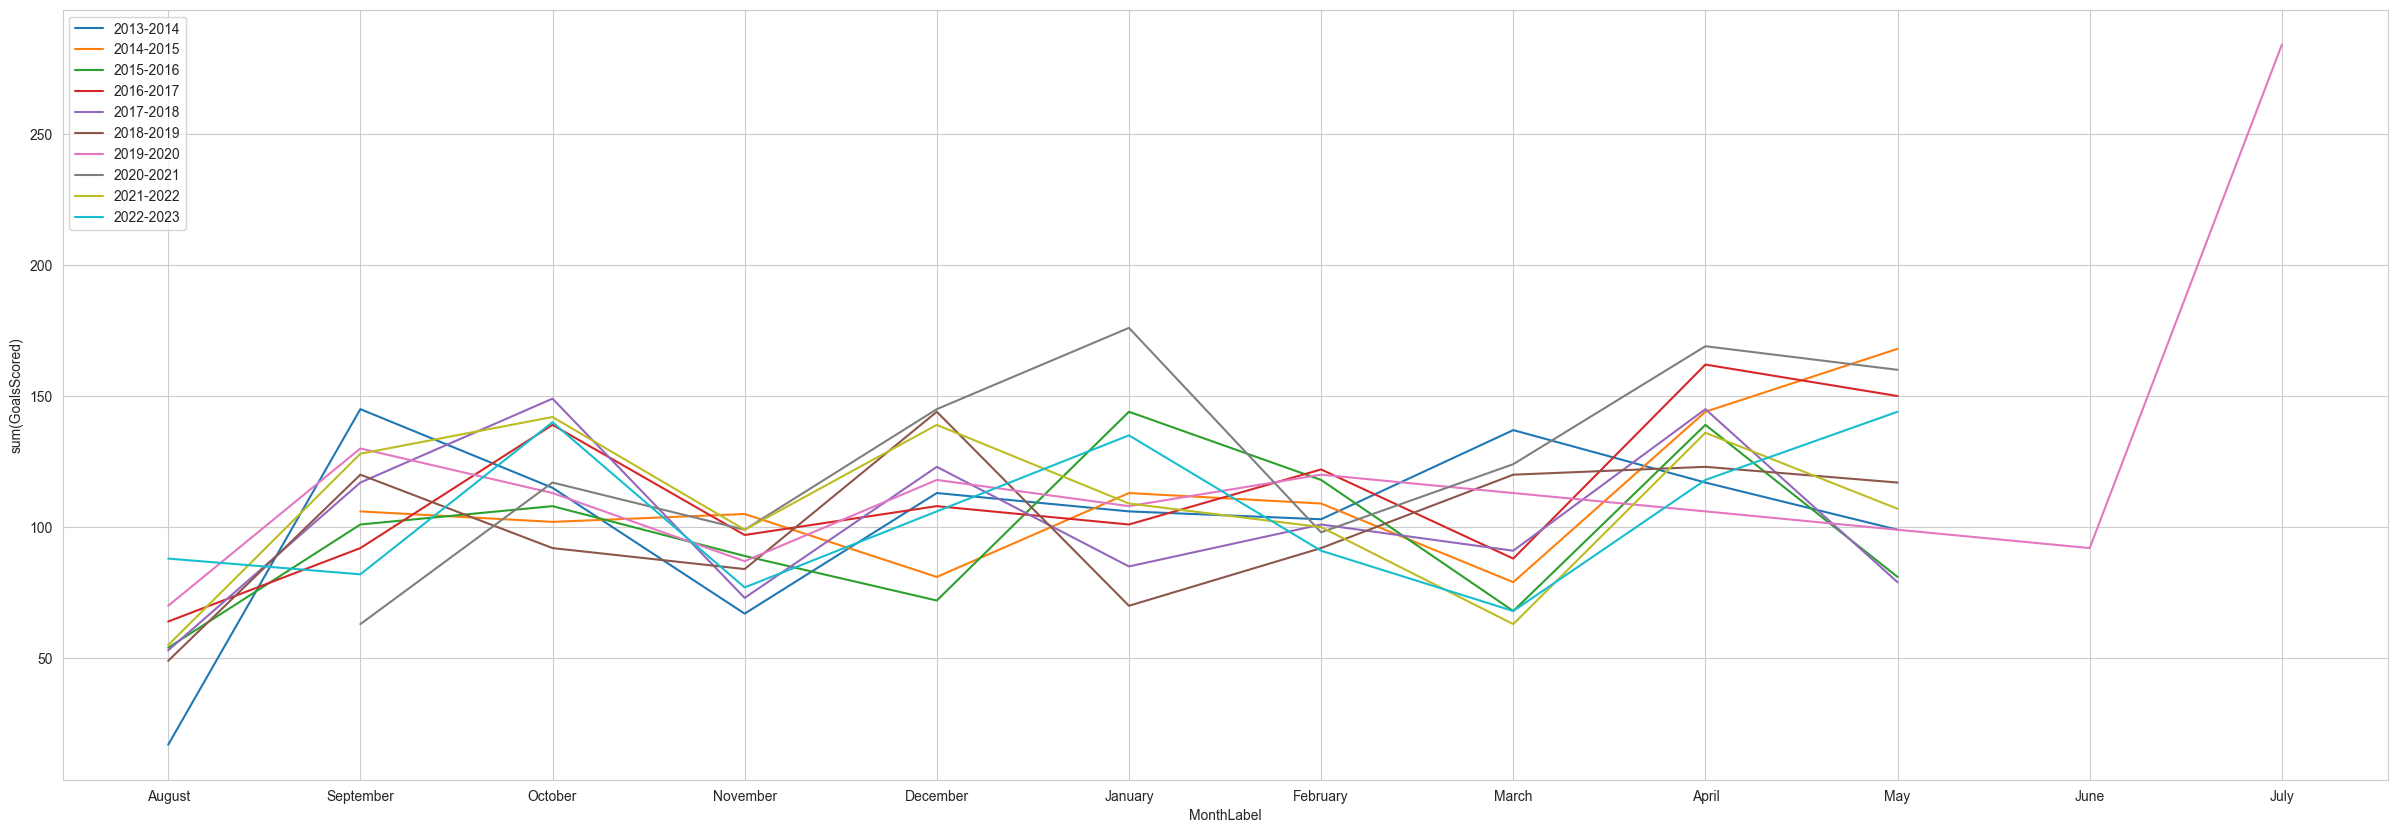

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
fig,ax = plt.subplots(figsize=(30,10))
for season in monthly_goals_pandas['Season'].unique():
    season_data = monthly_goals_pandas[monthly_goals_pandas['Season'] == season]
    sns.lineplot(x = season_data['MonthLabel'], y = season_data['sum(GoalsScored)'], label=season,ax =ax)
    sns.set_style("whitegrid")
    ax.legend()

In [39]:
#What's the best month to watch Serie A
#find which month of the season has the highest average goals scored in the league
#, include date and month in groupby transformation, do total of goals scored based on season and monthly window.
testing = monthly_goals.groupBy('Month','MonthLabel').agg(avg('sum(GoalsScored)').alias('Average'))
testing.toPandas()
#may and october have highest average of goals scored

,Month,MonthLabel,Average
0,1,January,114.700000
1,8,August,56.250000
2,11,November,87.700000
3,9,September,108.400000
4,6,June,92.000000
5,3,March,93.111111
6,7,July,284.000000
7,12,December,115.888889
8,10,October,121.700000
9,5,May,122.777778
